In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [30]:
#https://drive.google.com/file/d/1Cj_gZFUmvegKICLQxSuPRk0QT5zvtPgK/view?usp=drive_link
#https://drive.google.com/file/d/1HObEZNhDxOCCFcVnRQzW9y3w4nd_yiDx/view?usp=drive_link
#https://drive.google.com/file/d/1ovu6KTPb8bc0h06A2nvy-kahAmecQjhy/view?usp=drive_link
your_file_all = drive.CreateFile({'id':'1Cj_gZFUmvegKICLQxSuPRk0QT5zvtPgK'})
your_file_ta = drive.CreateFile({'id':'1HObEZNhDxOCCFcVnRQzW9y3w4nd_yiDx'})
your_file_oc = drive.CreateFile({'id':'1ovu6KTPb8bc0h06A2nvy-kahAmecQjhy'})

In [31]:
your_file_all.GetContentFile('bitcoin-all-on-chain-and-technical-indicators.csv')
your_file_ta.GetContentFile('bitcoin-all-technical-indicators.csv')
your_file_oc.GetContentFile('bitcoin-all-on-chain.csv')

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
ta_df = pd.read_csv('bitcoin-all-technical-indicators.csv')
ta_df['timestamp'] = pd.to_datetime(ta_df['timestamp'])
ta_df.set_index('timestamp', inplace=True)
#ta_df = ta_df.dropna()
ta_df_returns = ta_df.pct_change()
# Replace infinities with NaN
ta_df_returns = ta_df_returns.replace([np.inf, -np.inf], np.nan)
ta_df_returns.fillna(0, inplace=True)
result = count_value_types(ta_df)
print("Value counts by type ta_df:")
for value_type, count in result.items():
    print(f"{value_type}: {count}")

oc_df = pd.read_csv('bitcoin-all-on-chain.csv')
oc_df['timestamp'] = pd.to_datetime(oc_df['timestamp'])
oc_df.set_index('timestamp', inplace=True)
result = count_value_types(oc_df)
print("Value counts by type oc_df:")
for value_type, count in result.items():
    print(f"{value_type}: {count}")
oc_df_returns = oc_df.pct_change()
oc_df_returns = oc_df_returns.replace([np.inf, -np.inf], np.nan)
oc_df_returns.fillna(0, inplace=True)

oc_ta_df = pd.read_csv('bitcoin-all-on-chain-and-technical-indicators.csv')
oc_ta_df['timestamp'] = pd.to_datetime(oc_ta_df['timestamp'])
oc_ta_df.set_index('timestamp', inplace=True)
oc_ta_df_returns = oc_ta_df.pct_change()
oc_ta_df_returns = oc_ta_df_returns.replace([np.inf, -np.inf], np.nan)
oc_ta_df_returns.fillna(0, inplace=True)

price_only_df = ta_df[['price']]
price_only_df_returns = price_only_df.pct_change()
price_only_df_returns = price_only_df_returns.dropna()

Value counts by type ta_df:
float: 224840
int: 32120
Value counts by type oc_df:
float: 274480
int: 61320


In [33]:
import pandas as pd
import numpy as np

def count_value_types(df):
    type_counts = {}

    for column in df.columns:
        values = df[column]
        for value in values:
            value_type = type(value).__name__
            if value_type in type_counts:
                type_counts[value_type] += 1

            else:
                type_counts[value_type] = 1



    return type_counts


In [35]:
def plot_values(timestamp, *args):
    import matplotlib

    if len(args) % 2 != 0:
        raise ValueError("Every feature should have a corresponding name")

    # Use a predefined style
    plt.style.use('ggplot')

    # Set figure size
    fig, ax = plt.subplots(figsize=(12,6))

    # Create a colormap that will generate colors
    colormap = matplotlib.colormaps['tab10']

    # Plot data with customized line for each feature
    for i in range(0, len(args), 2):
        feature_name = args[i]
        feature_values = args[i+1]
        color = colormap(i // 2 / (len(args)//2))
        ax.plot(timestamp, feature_values, label=feature_name, color=color, linewidth=1)

    # Set labels with improved readability
    ax.set_xlabel('Date')
    ax.yaxis.set_label_position("right") # This line moves y label to the right
    ax.set_ylabel('Feature Values')
    ax.yaxis.tick_right() # This line moves y axis to the right
    ax.set_title('Features over Time')

    # Format the timestamps and set locator
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format as year-month-day
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # display a label at the start of every 3rd month

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add a grid
    ax.grid(True)

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

In [36]:
def data_preparation(df, target_column, lookback, future, features_scaler, target_scaler, test_size=0.1):
    # Separate features and target variable
    features = df.drop(target_column, axis=1)
    target = df[[target_column]]

    # Split data into training and testing before scaling
    features_train, features_test = train_test_split(features, test_size=test_size, shuffle=False)
    target_train, target_test = train_test_split(target, test_size=test_size, shuffle=False)

    # Scale features
    features_train_scaled = features_scaler.fit_transform(features_train)
    features_test_scaled = features_scaler.transform(features_test)

    # Scale target
    target_train_scaled = target_scaler.fit_transform(target_train)
    target_test_scaled = target_scaler.transform(target_test)

    # Create the feature and target arrays
    X_train, y_train = [], []
    for i in range(lookback, len(features_train_scaled)-future+1):
        X_train.append(features_train_scaled[i-lookback:i, :])
        y_train.append(target_train_scaled[i+future-1:i+future, 0])

    X_test, y_test = [], []
    for i in range(lookback, len(features_test_scaled)-future+1):
        X_test.append(features_test_scaled[i-lookback:i, :])
        y_test.append(target_test_scaled[i+future-1:i+future, 0])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test


In [37]:
def lstm_1(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)

    model.add(Bidirectional(LSTM(units=256, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y, validation_split=0.1, epochs=50, batch_size=32)
    return model

In [38]:
def lstm_2(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)

    model.add(LSTM(units=256, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y, validation_split=0.1, epochs=50, batch_size=32)
    return model

In [39]:
from keras.regularizers import l2

def lstm_3(X, y):
    model_name="lstm_3_"+str(int(time.time()))
    model=Sequential(name=model_name)

    model.add(LSTM(512, return_sequences=True, input_shape=(X.shape[1], X.shape[2]), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(X, y, validation_split=0.1, epochs=100, batch_size=32, verbose=1)

    return model

In [40]:
def predict_price(df):
    features_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    X_train, X_test, y_train, y_test = data_preparation(df, 'price', 60, 1, features_scaler, target_scaler)

    model=lstm_1(X_train, y_train)
    predictions = model.predict(X_test)

    # Now you can inverse_transform your predictions
    predictions = target_scaler.inverse_transform(predictions)
    y_test = y_test.reshape(-1, 1)  # reshaping
    y_test = target_scaler.inverse_transform(y_test)


    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)
    print("Mean Absolute Error (MAE):", mae)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, predictions)
    print("Mean Squared Error (MSE):", mse)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print("Root Mean Squared Error (RMSE):", rmse)

    # Mean Absolute Percentage Error (MAPE)
    epsilon = 1e-10  # small constant to prevent division by zero
    mape = np.mean(np.abs((y_test - predictions) / (y_test + epsilon))) * 100
    print("Mean Absolute Percentage Error (MAPE):", mape)

    # R-squared (R2)
    r2 = r2_score(y_test, predictions)
    print("R-squared (R2):", r2)

    # Correct Direction Prediction
    test_diff = np.diff(y_test.reshape(-1), axis=0)
    pred_diff = np.diff(predictions.reshape(-1), axis=0)
    test_direction = np.sign(test_diff)
    pred_direction = np.sign(pred_diff)
    correct_predictions = np.sum(test_direction == pred_direction)
    print(f'The model predicted the correct direction {correct_predictions} times out of {len(test_direction)}.')

    plot_values(range(len(y_test)), 'test', y_test, 'predictions', predictions)



Epoch 1/50
73/73 [==============================] - 17s 36ms/step - loss: 0.0953 - val_loss: 0.0057
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 7.4643e-04 - val_loss: 0.0025
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 5.6609e-04 - val_loss: 0.0025
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 4.3070e-04 - val_loss: 0.0019
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 3.7432e-04 - val_loss: 0.0019
Epoch 6/50
73/73 [==============================] - 2s 21ms/step - loss: 4.1019e-04 - val_loss: 0.0019
Epoch 7/50
73/73 [==============================] - 2s 25ms/step - loss: 3.6702e-04 - val_loss: 0.0024
Epoch 8/50
73/73 [==============================] - 1s 18ms/step - loss: 3.6193e-04 - val_loss: 0.0016
Epoch 9/50
73/73 [==============================] - 1s 17ms/step - loss: 2.9863e-04 - val_loss: 0.0016
Epoch 10/50
73/73 [==============================] - 1s 18ms/step - loss: 2.

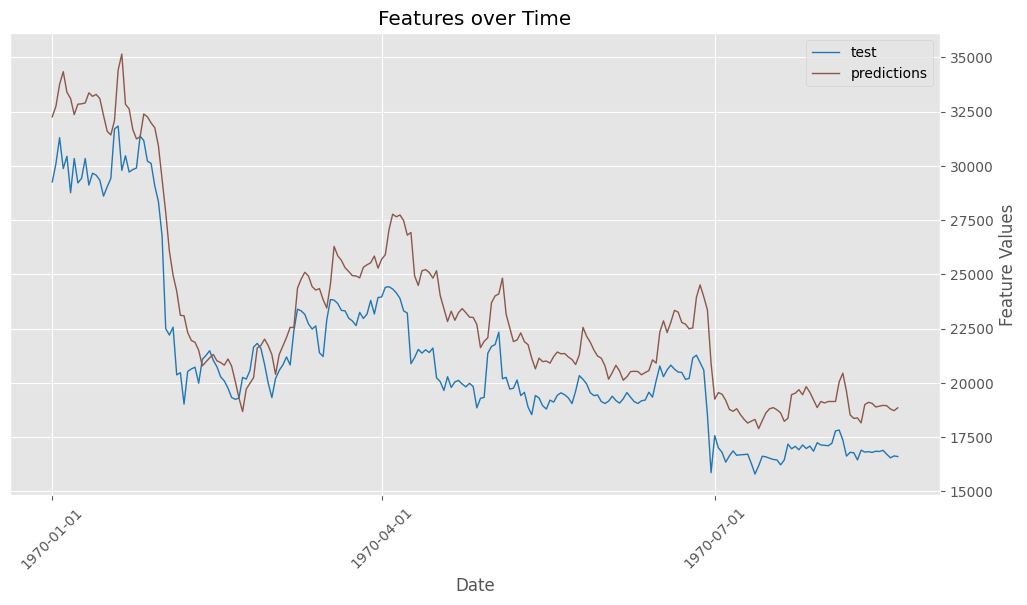

Epoch 1/50
73/73 [==============================] - 11s 42ms/step - loss: 0.1389 - val_loss: 0.0030
Epoch 2/50
73/73 [==============================] - 2s 24ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 3/50
73/73 [==============================] - 2s 21ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 6/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 7/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 8/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 9/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 11

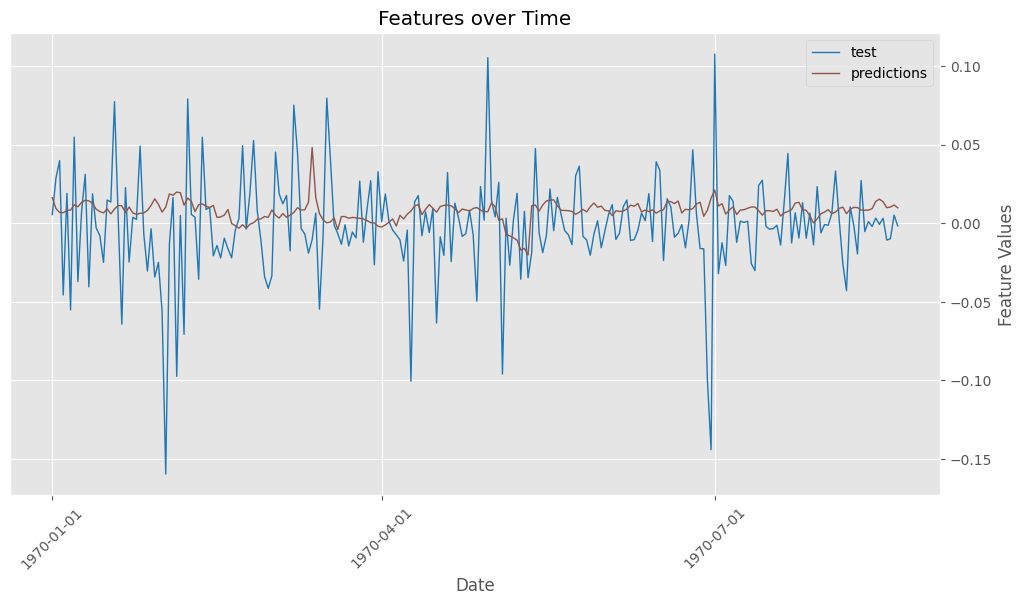

Epoch 1/50
73/73 [==============================] - 11s 45ms/step - loss: 0.1315 - val_loss: 0.0170
Epoch 2/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0154
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 6.7186e-04 - val_loss: 0.0394
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 5.1413e-04 - val_loss: 0.0374
Epoch 5/50
73/73 [==============================] - 1s 18ms/step - loss: 5.2575e-04 - val_loss: 0.0277
Epoch 6/50
73/73 [==============================] - 1s 19ms/step - loss: 4.4404e-04 - val_loss: 0.0263
Epoch 7/50
73/73 [==============================] - 1s 18ms/step - loss: 3.7785e-04 - val_loss: 0.0294
Epoch 8/50
73/73 [==============================] - 1s 19ms/step - loss: 5.2954e-04 - val_loss: 0.0143
Epoch 9/50
73/73 [==============================] - 2s 25ms/step - loss: 3.4961e-04 - val_loss: 0.0312
Epoch 10/50
73/73 [==============================] - 2s 25ms/step - loss: 3.5571

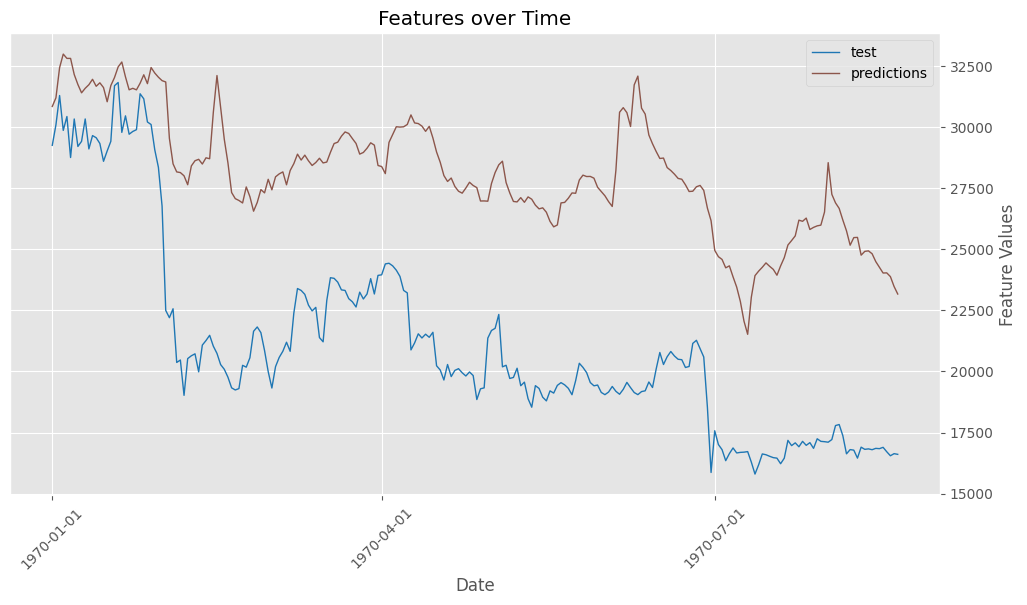

Epoch 1/50
73/73 [==============================] - 11s 35ms/step - loss: 0.1208 - val_loss: 0.0031
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 4/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 5/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 6/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 7/50
73/73 [==============================] - 2s 24ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 8/50
73/73 [==============================] - 2s 23ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 9/50
73/73 [==============================] - 1s 19ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 10/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 11

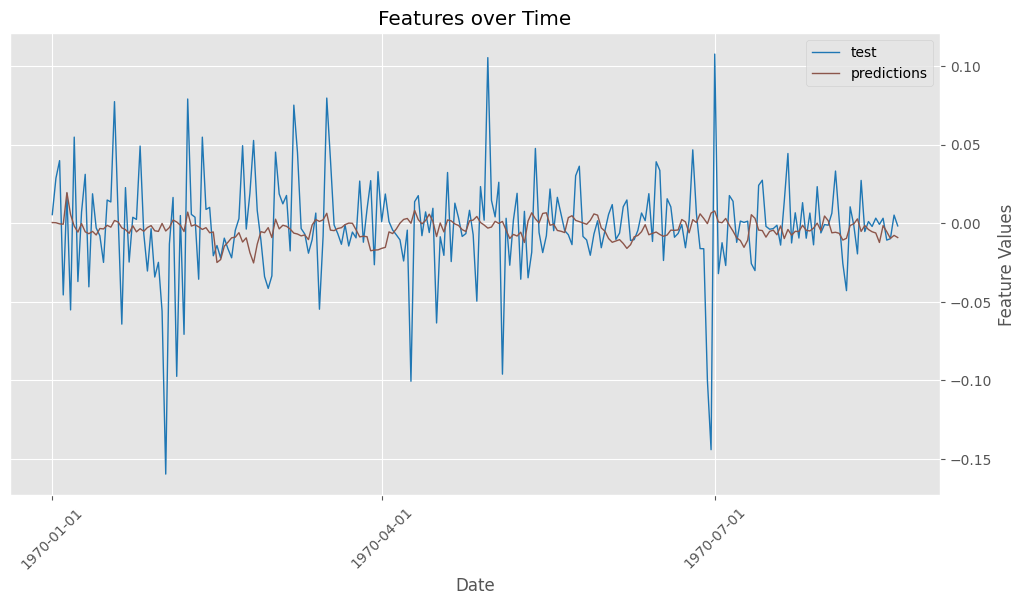

Epoch 1/50
73/73 [==============================] - 11s 39ms/step - loss: 0.2672 - val_loss: 0.0115
Epoch 2/50
73/73 [==============================] - 2s 27ms/step - loss: 0.0015 - val_loss: 0.0055
Epoch 3/50
73/73 [==============================] - 2s 24ms/step - loss: 9.5820e-04 - val_loss: 0.0072
Epoch 4/50
73/73 [==============================] - 1s 19ms/step - loss: 7.0450e-04 - val_loss: 0.0034
Epoch 5/50
73/73 [==============================] - 1s 19ms/step - loss: 6.3558e-04 - val_loss: 0.0029
Epoch 6/50
73/73 [==============================] - 1s 19ms/step - loss: 5.0488e-04 - val_loss: 0.0045
Epoch 7/50
73/73 [==============================] - 1s 20ms/step - loss: 4.6844e-04 - val_loss: 0.0019
Epoch 8/50
73/73 [==============================] - 1s 19ms/step - loss: 4.8302e-04 - val_loss: 0.0034
Epoch 9/50
73/73 [==============================] - 1s 18ms/step - loss: 5.0488e-04 - val_loss: 0.0030
Epoch 10/50
73/73 [==============================] - 1s 20ms/step - loss: 4.0981

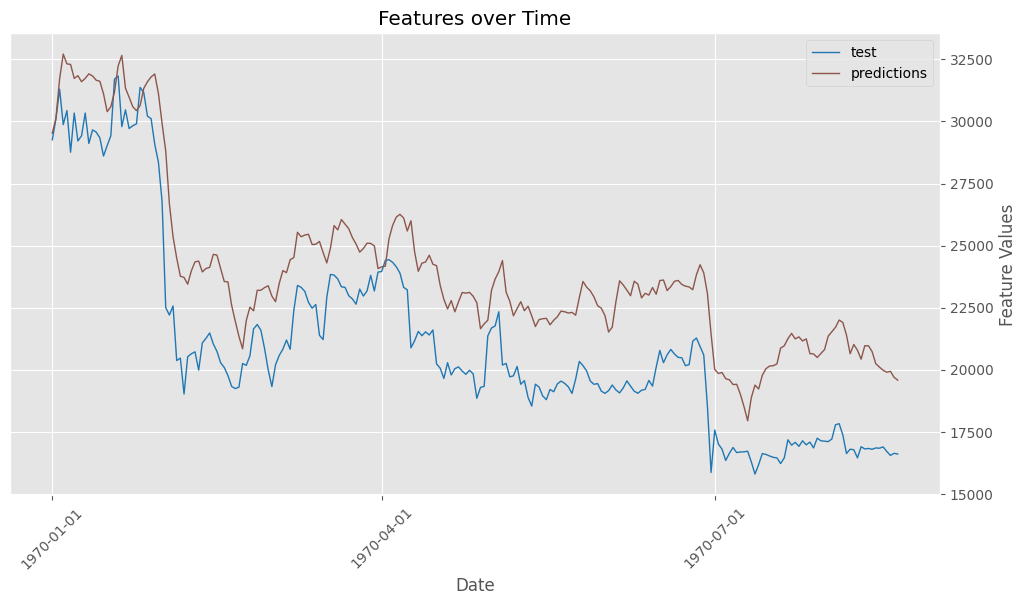

Epoch 1/50
73/73 [==============================] - 11s 44ms/step - loss: 0.2559 - val_loss: 0.0031
Epoch 2/50
73/73 [==============================] - 2s 25ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/50
73/73 [==============================] - 1s 20ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 4/50
73/73 [==============================] - 1s 20ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 5/50
73/73 [==============================] - 1s 19ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 6/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 7/50
73/73 [==============================] - 1s 19ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 8/50
73/73 [==============================] - 1s 19ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 9/50
73/73 [==============================] - 1s 20ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/50
73/73 [==============================] - 2s 26ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 11

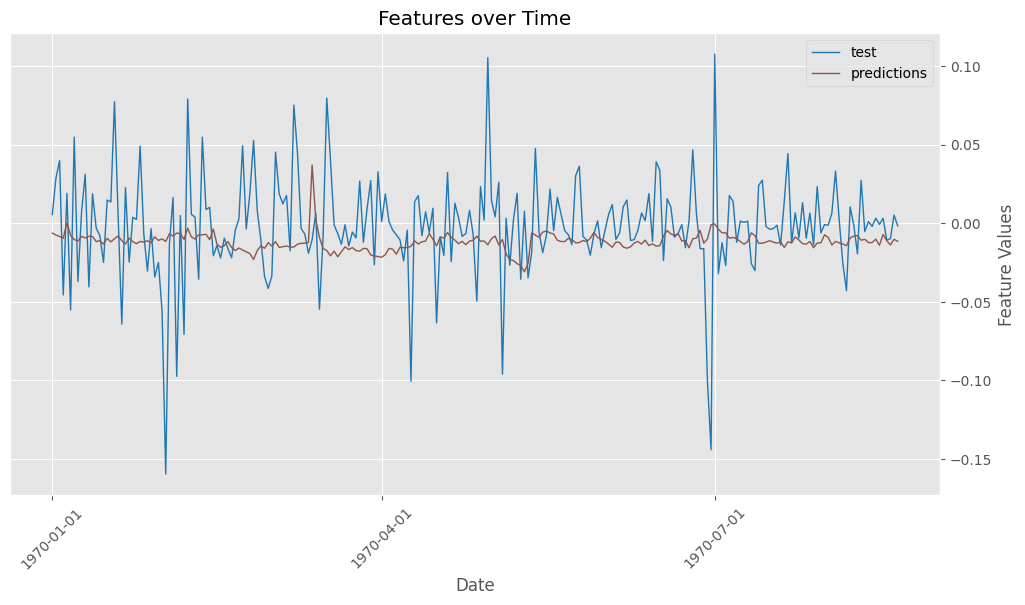

In [41]:
#lstm_2, units per layer: 256, 128, 64
predict_price(ta_df)
predict_price(ta_df_returns)

predict_price(oc_df)
predict_price(oc_df_returns)

predict_price(oc_ta_df)
predict_price(oc_ta_df_returns)
